In [1]:
import pandas as pd
import optuna
import warnings
import shap

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from tqdm import tqdm_notebook
from datetime import datetime
import os

warnings.filterwarnings("ignore")

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [5]:
!wget https://www.dropbox.com/s/ptq7w319cc0epj4/data.zip
!unzip data.zip
!rm data.zip

--2022-06-24 08:09:08--  https://www.dropbox.com/s/ptq7w319cc0epj4/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ptq7w319cc0epj4/data.zip [following]
--2022-06-24 08:09:08--  https://www.dropbox.com/s/raw/ptq7w319cc0epj4/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9927674889fdad50a33e6bd247.dl.dropboxusercontent.com/cd/0/inline/Bnw0k-hKj1qcOzQqeeTJACPIqCUnPQeIBIfZakEA973aUIwDJR2TxylXa40Xt34R3ifphG5O98tk9VCwiC9xRyXKooeNWJ4Pdrmjt7BlbovcEqCQucq1iAEvmsnEDmI0HIkHkGjEGCr6FLiECyp01gKub0xoVECsmWRmdF81bWrYLQ/file# [following]
--2022-06-24 08:09:09--  https://uc9927674889fdad50a33e6bd247.dl.dropboxusercontent.com/cd/0/inline/Bnw0k-hKj1qcOzQqeeTJACPIqCUnPQeIBIfZakEA973aUIwDJR2TxylXa40Xt34R3ifphG5O98tk9

In [6]:
from preprocessing import prep
from optimization import get_best_params, get_best_model_params
from config import DATA_PATH, MODEL_PATH, selected_feats, targets, MODEL_VERSION

In [7]:
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

In [8]:
def read_files(DATA_PATH):
    test_df = pd.read_csv(f'{DATA_PATH}/test_dataset_test.csv')
    train_df = pd.read_csv(f'{DATA_PATH}/train.csv')
    return train_df, test_df

In [9]:
train_df, test_df = read_files(DATA_PATH)

In [10]:
train_df = prep(train_df)
test_df = prep(test_df)

In [11]:
### FIT MODELS
for j, i in enumerate(targets):
    # TRAIN-VAL-SPLIT (random)
    tr_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df[i], random_state=123)
    if j == 0:
        cb = CatBoostClassifier(max_depth=4, learning_rate=0.01, eval_metric='AUC', verbose=1000, early_stopping_rounds=50)
    elif j == 3:
        cb = CatBoostClassifier(max_depth=2, eval_metric='AUC', verbose=1000, early_stopping_rounds=50)
    elif j == 1:
        cb = CatBoostClassifier(max_depth=2, n_estimators=300, eval_metric='AUC', verbose=1000, early_stopping_rounds=50)
    elif j == 4:
        cb = CatBoostClassifier(max_depth=2, learning_rate=0.001, eval_metric='AUC', verbose=1000, early_stopping_rounds=50)
    else:
        cb = CatBoostClassifier(max_depth=1, learning_rate=0.015, eval_metric='AUC', verbose=1000, early_stopping_rounds=50)
    train_pool = Pool(tr_df[selected_feats[i]], tr_df[i])
    val_pool = Pool(val_df[selected_feats[i]], val_df[i])
    test_pool = Pool(test_df[selected_feats[i]])
    cb.fit(train_pool, eval_set = val_pool)
    cb.save_model(f'{MODEL_PATH}/{i}_{MODEL_VERSION}.cbm')

0:	test: 0.7195968	best: 0.7195968 (0)	total: 47.4ms	remaining: 47.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7566644635
bestIteration = 21

Shrink model to first 22 iterations.
Learning rate set to 0.050059
0:	test: 0.4439891	best: 0.4439891 (0)	total: 573us	remaining: 171ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6905737705
bestIteration = 64

Shrink model to first 65 iterations.
0:	test: 0.4334886	best: 0.4334886 (0)	total: 467us	remaining: 467ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7807971014
bestIteration = 54

Shrink model to first 55 iterations.
Learning rate set to 0.029651
0:	test: 0.7272032	best: 0.7272032 (0)	total: 515us	remaining: 515ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8061505508
bestIteration = 32

Shrink model to first 33 iterations.
0:	test: 0.4056795	best: 0.4056795 (0)	total: 555us	remaining: 555ms
Stopped by overfitting detector  (50 iterations wa

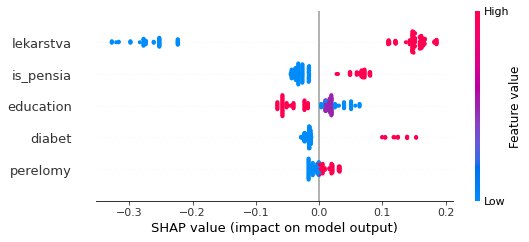

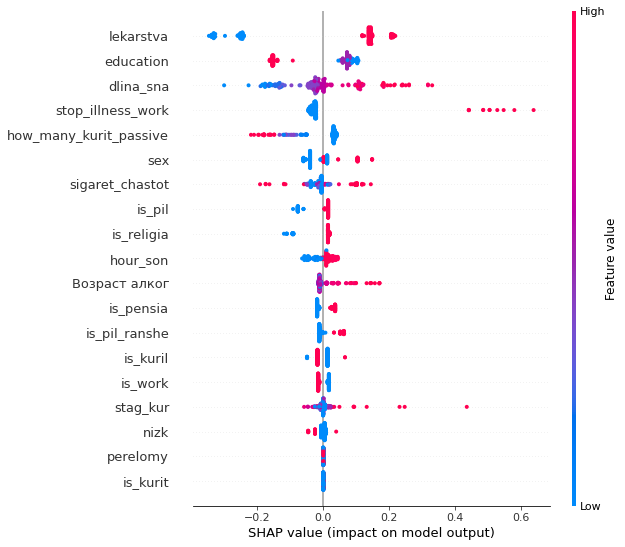

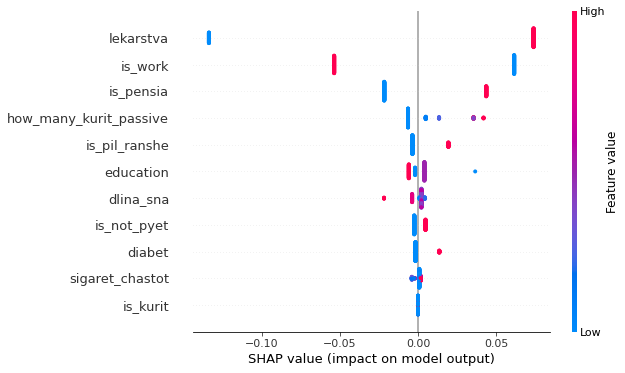

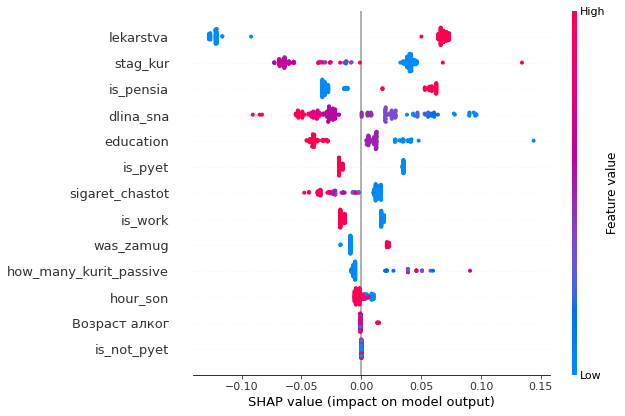

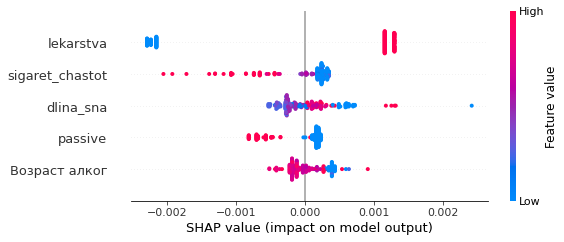

In [12]:
# Важные переменные
for j, i in enumerate(targets):
    tr_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df[i], random_state=123)
    b = CatBoostClassifier(max_depth=3, learning_rate=0.01, eval_metric='AUC', verbose=1000, early_stopping_rounds=50)
    train_pool = Pool(tr_df[selected_feats[i]], tr_df[i])
    val_pool = Pool(val_df[selected_feats[i]], val_df[i])
    test_pool = Pool(test_df[selected_feats[i]])
    cb.load_model(f'{MODEL_PATH}/{i}_{MODEL_VERSION}.cbm')
    shap.summary_plot(cb.get_feature_importance(val_pool, type='ShapValues')[:, :-1], val_df[cb.feature_names_])

In [13]:
def implement_model(val_df):
    cb = CatBoostClassifier()
    for i in targets:
        cb.load_model(f'{MODEL_PATH}/{i}_{MODEL_VERSION}.cbm')   
        val_pool = Pool(val_df[cb.feature_names_])
        val_df[f'sc_{i}'] = cb.predict_proba(val_pool)[:,1]
    return val_df

In [14]:
val_df = implement_model(val_df)
test_df = implement_model(test_df)

### Подберём пороги бинаризации

In [15]:
all_prs = []
all_scr = []
for i, target in enumerate(targets):
    prs, sc = get_best_params(val_df, target, 500, i, direction='maximize')
    all_prs.append(prs)
    all_scr.append(sc)

In [16]:
for number, (param, scor) in enumerate(zip(all_prs, all_scr)):
    print(f"""The best treshold for 
    target {targets[number]} is {param[f'param_{number}']:.4} with scor = {scor:.4}
    """)

The best treshold for 
    target Артериальная гипертензия is 0.4294 with scor = 0.741
    
The best treshold for 
    target ОНМК is 0.05671 with scor = 0.7144
    
The best treshold for 
    target Стенокардия, ИБС, инфаркт миокарда is 0.2417 with scor = 0.7816
    
The best treshold for 
    target Сердечная недостаточность is 0.2082 with scor = 0.7395
    
The best treshold for 
    target Прочие заболевания сердца is 0.4893 with scor = 0.628
    


In [17]:
for j, i in enumerate(targets):
    test_df[i] = (test_df[f'sc_{i}']>all_prs[j][f'param_{j}'])
    val_df[i] = (val_df[f'sc_{i}']>all_prs[j][f'param_{j}'])

In [18]:
val_df[targets].mean()

Артериальная гипертензия              0.649215
ОНМК                                  0.193717
Стенокардия, ИБС, инфаркт миокарда    0.465969
Сердечная недостаточность             0.361257
Прочие заболевания сердца             0.649215
dtype: float64

In [19]:
test_df[targets].mean()

Артериальная гипертензия              0.606583
ОНМК                                  0.177116
Стенокардия, ИБС, инфаркт миокарда    0.391850
Сердечная недостаточность             0.277429
Прочие заболевания сердца             0.623824
dtype: float64

In [20]:
print('Scor on validate = ', round(sum(all_scr) / 5, 5))

Scor on validate =  0.72087


In [21]:
dt = str(datetime.today()).split()[0].replace('-','')[4:]

In [22]:
test_df[["ID"]+targets].to_csv(f'solution_{dt}_{MODEL_VERSION}.csv', index=False)

### PUBLIC SCORE = 0.715238